In [1]:
import os
import os.path
import glob
import time

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold                              
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report
import matplotlib.pyplot as plt
import matplotlib.cm as colormap

import numpy as np
np.random.seed(1)

from keras.utils import np_utils
from keras.preprocessing import image
from keras.applications.vgg19 import VGG19
from keras.applications.imagenet_utils import preprocess_input
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import Sequential,Model
from keras.layers import Input,Flatten,Dense,Dropout,GlobalAveragePooling2D,Conv2D,MaxPooling2D
from keras.optimizers import SGD

os.environ['CUDA_VISIBLE_DEVICES'] = '0'

Using TensorFlow backend.


In [2]:
imagedir = "Datasets/malimg_paper_dataset_imgs"

In [3]:
cur_dir = os.getcwd()
os.chdir(imagedir)  # the parent folder with sub-folders

# Get number of samples per family
list_fams = sorted(os.listdir(os.getcwd()), key=str.lower)  # vector of strings with family names
no_imgs = []  # No. of samples per family
for i in range(len(list_fams)):
    os.chdir(list_fams[i])
    len1 = len(glob.glob('*.png'))  # assuming the images are stored as 'png'
    no_imgs.append(len1)
    os.chdir('..')
num_samples = np.sum(no_imgs)  # total number of all samples

# Compute the labels
y = np.zeros(num_samples)
pos = 0
label = 0
for i in no_imgs:
    print ("Label:%2d\tFamily: %15s\tNumber of images: %d" % (label, list_fams[label], i))
    for j in range(i):
        y[pos] = label
        pos += 1
    label += 1
num_classes = label

# Compute the features
width, height,channels = (224,224,3)
X = np.zeros((num_samples, width, height, channels))
cnt = 0
list_paths = [] # List of image paths
print("Processing images ...")
for i in range(len(list_fams)):
    for img_file in glob.glob(list_fams[i]+'/*.png'):
        #print("[%d] Processing image: %s" % (cnt, img_file))
        list_paths.append(os.path.join(os.getcwd(),img_file))
        img = image.load_img(img_file, target_size=(224, 224))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
        X[cnt] = x
        cnt += 1
print("Images processed: %d" %(cnt))

os.chdir(cur_dir)

Label: 0	Family:       Adialer.C	Number of images: 122
Label: 1	Family:       Agent.FYI	Number of images: 116
Label: 2	Family:       Allaple.A	Number of images: 2949
Label: 3	Family:       Allaple.L	Number of images: 1591
Label: 4	Family:   Alueron.gen!J	Number of images: 198
Label: 5	Family:       Autorun.K	Number of images: 106
Label: 6	Family:     C2LOP.gen!g	Number of images: 200
Label: 7	Family:         C2LOP.P	Number of images: 146
Label: 8	Family:  Dialplatform.B	Number of images: 177
Label: 9	Family:       Dontovo.A	Number of images: 162
Label:10	Family:        Fakerean	Number of images: 381
Label:11	Family:   Instantaccess	Number of images: 431
Label:12	Family:      Lolyda.AA1	Number of images: 213
Label:13	Family:      Lolyda.AA2	Number of images: 184
Label:14	Family:      Lolyda.AA3	Number of images: 123
Label:15	Family:       Lolyda.AT	Number of images: 159
Label:16	Family:     Malex.gen!J	Number of images: 136
Label:17	Family:   Obfuscator.AD	Number of images: 142
Label:18

In [4]:
X.shape

(9339, 224, 224, 3)

In [5]:
# Encoding classes (y) into integers (y_encoded) and then generating one-hot-encoding (Y)
encoder = LabelEncoder()
encoder.fit(y)
y_encoded = encoder.transform(y)
Y = np_utils.to_categorical(y_encoded)

In [6]:
# Creating base_model (VGG19 notop)
image_shape = (224, 224, 3)                                                                                                                                                                                                                                                                                            
base_model = VGG19(weights='imagenet', input_shape=image_shape, include_top=False, pooling=None)

In [7]:
# Adding the top layer
x = Flatten(name='flatten')(base_model.output)
x = Dense(4096, activation='relu', name='fc1')(x)
x = Dense(4096, activation='relu', name='fc2')(x)
predictions = Dense(num_classes, activation='softmax', name='predictions')(x)
model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [8]:
# Create stratified k-fold subsets                                                                                                                                        
kfold = 10  # no. of folds                                                                 
skf = StratifiedKFold(kfold, shuffle=True,random_state=1)
skfind = [None] * kfold  # skfind[i][0] -> train indices, skfind[i][1] -> test indices
cnt = 0                                              
for index in skf.split(X, y):         
    skfind[cnt] = index                                                 
    cnt += 1 

In [9]:
# Fine-tuning the model (base_model + top layer) 
num_epochs=100
history = []
conf_mat = np.zeros((len(list_fams),len(list_fams))) # Initializing the Confusion Matrix
checkpointer = ModelCheckpoint(filepath='malimg-vgg19-finetune.h5', monitor='val_acc', verbose=0, save_best_only=True, save_weights_only=True, mode='auto')
callbacks_list = [checkpointer]
init_weights = model.get_weights()

In [10]:
for i in range(kfold):
    train_indices = skfind[i][0]
    test_indices = skfind[i][1]
    X_train = X[train_indices]
    Y_train = Y[train_indices]
    X_test = X[test_indices]
    Y_test = Y[test_indices]
    y_test = y[test_indices]

    model.set_weights(init_weights)
    
    y_prob = model.predict(X_test, verbose=0)  # Testing
    y_pred = np.argmax(y_prob, axis=1)
    print("[%d] Initial acurracy: %.4f" %(i,accuracy_score(y_test,y_pred)))

    start = time.time()
    h = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=num_epochs, batch_size=64, verbose=1, callbacks=callbacks_list)
    end = time.time()
    history.append(h)
    
    y_prob = model.predict(X_test, verbose=1)  # Testing
    y_pred = np.argmax(y_prob, axis=1)
    print("[%d] Test acurracy: %.4f (%.4f s)" %(i,accuracy_score(y_test,y_pred),end-start))
    
    cm = confusion_matrix(y_test,y_pred)  # Compute confusion matrix for this fold
    conf_mat = conf_mat + cm  # Compute global confusion matrix

[0] Initial acurracy: 0.2360
Train on 8394 samples, validate on 945 samples
Epoch 1/100
8394/8394 [==============================] - 116s - loss: 10.9813 - acc: 0.3171 - val_loss: 11.0865 - val_acc: 0.3122
Epoch 2/100
8394/8394 [==============================] - 112s - loss: 11.0219 - acc: 0.3162 - val_loss: 11.0865 - val_acc: 0.3122
Epoch 3/100
8394/8394 [==============================] - 113s - loss: 11.0219 - acc: 0.3162 - val_loss: 11.0865 - val_acc: 0.3122
Epoch 4/100
8394/8394 [==============================] - 112s - loss: 11.0219 - acc: 0.3162 - val_loss: 11.0865 - val_acc: 0.3122
Epoch 5/100
8394/8394 [==============================] - 112s - loss: 11.0219 - acc: 0.3162 - val_loss: 11.0865 - val_acc: 0.3122
Epoch 6/100
8394/8394 [==============================] - 113s - loss: 11.0219 - acc: 0.3162 - val_loss: 11.0865 - val_acc: 0.3122
Epoch 7/100
8394/8394 [==============================] - 112s - loss: 11.0219 - acc: 0.3162 - val_loss: 11.0865 - val_acc: 0.3122
Epoch 8/100
83

8394/8394 [==============================] - 113s - loss: 11.0219 - acc: 0.3162 - val_loss: 11.0865 - val_acc: 0.3122
Epoch 64/100
8394/8394 [==============================] - 114s - loss: 11.0219 - acc: 0.3162 - val_loss: 11.0865 - val_acc: 0.3122
Epoch 65/100
8394/8394 [==============================] - 113s - loss: 11.0219 - acc: 0.3162 - val_loss: 11.0865 - val_acc: 0.3122
Epoch 66/100
8394/8394 [==============================] - 113s - loss: 11.0219 - acc: 0.3162 - val_loss: 11.0865 - val_acc: 0.3122
Epoch 67/100
8394/8394 [==============================] - 113s - loss: 11.0219 - acc: 0.3162 - val_loss: 11.0865 - val_acc: 0.3122
Epoch 68/100
8394/8394 [==============================] - 113s - loss: 11.0219 - acc: 0.3162 - val_loss: 11.0865 - val_acc: 0.3122
Epoch 69/100
8394/8394 [==============================] - 113s - loss: 11.0219 - acc: 0.3162 - val_loss: 11.0865 - val_acc: 0.3122
Epoch 70/100
8394/8394 [==============================] - 113s - loss: 11.0219 - acc: 0.3162 - v

8397/8397 [==============================] - 114s - loss: 11.0237 - acc: 0.3161 - val_loss: 11.0705 - val_acc: 0.3132
Epoch 87/100
8397/8397 [==============================] - 113s - loss: 11.0237 - acc: 0.3161 - val_loss: 11.0705 - val_acc: 0.3132
Epoch 88/100
8397/8397 [==============================] - 114s - loss: 11.0237 - acc: 0.3161 - val_loss: 11.0705 - val_acc: 0.3132
Epoch 89/100
8397/8397 [==============================] - 113s - loss: 11.0237 - acc: 0.3161 - val_loss: 11.0705 - val_acc: 0.3132
Epoch 90/100
8397/8397 [==============================] - 114s - loss: 11.0237 - acc: 0.3161 - val_loss: 11.0705 - val_acc: 0.3132
Epoch 91/100
8397/8397 [==============================] - 114s - loss: 11.0237 - acc: 0.3161 - val_loss: 11.0705 - val_acc: 0.3132
Epoch 92/100
8397/8397 [==============================] - 114s - loss: 11.0237 - acc: 0.3161 - val_loss: 11.0705 - val_acc: 0.3132
Epoch 93/100
8397/8397 [==============================] - 114s - loss: 11.0237 - acc: 0.3161 - v

8403/8403 [==============================] - 114s - loss: 11.0274 - acc: 0.3158 - val_loss: 11.0381 - val_acc: 0.3152
Epoch 9/100
8403/8403 [==============================] - 114s - loss: 11.0274 - acc: 0.3158 - val_loss: 11.0381 - val_acc: 0.3152
Epoch 10/100
8403/8403 [==============================] - 114s - loss: 11.0274 - acc: 0.3158 - val_loss: 11.0381 - val_acc: 0.3152
Epoch 11/100
8403/8403 [==============================] - 114s - loss: 11.0274 - acc: 0.3158 - val_loss: 11.0381 - val_acc: 0.3152
Epoch 12/100
8403/8403 [==============================] - 114s - loss: 11.0274 - acc: 0.3158 - val_loss: 11.0381 - val_acc: 0.3152
Epoch 13/100
8403/8403 [==============================] - 114s - loss: 11.0274 - acc: 0.3158 - val_loss: 11.0381 - val_acc: 0.3152
Epoch 14/100
8403/8403 [==============================] - 114s - loss: 11.0274 - acc: 0.3158 - val_loss: 11.0381 - val_acc: 0.3152
Epoch 15/100
8403/8403 [==============================] - 114s - loss: 11.0274 - acc: 0.3158 - va

8404/8404 [==============================] - 114s - loss: 11.0280 - acc: 0.3158 - val_loss: 11.0327 - val_acc: 0.3155
Epoch 32/100
8404/8404 [==============================] - 114s - loss: 11.0280 - acc: 0.3158 - val_loss: 11.0327 - val_acc: 0.3155
Epoch 33/100
8404/8404 [==============================] - 114s - loss: 11.0280 - acc: 0.3158 - val_loss: 11.0327 - val_acc: 0.3155
Epoch 34/100
8404/8404 [==============================] - 114s - loss: 11.0280 - acc: 0.3158 - val_loss: 11.0327 - val_acc: 0.3155
Epoch 35/100
8404/8404 [==============================] - 114s - loss: 11.0280 - acc: 0.3158 - val_loss: 11.0327 - val_acc: 0.3155
Epoch 36/100
8404/8404 [==============================] - 114s - loss: 11.0280 - acc: 0.3158 - val_loss: 11.0327 - val_acc: 0.3155
Epoch 37/100
8404/8404 [==============================] - 114s - loss: 11.0280 - acc: 0.3158 - val_loss: 11.0327 - val_acc: 0.3155
Epoch 38/100
8404/8404 [==============================] - 114s - loss: 11.0280 - acc: 0.3158 - v

8404/8404 [==============================] - 114s - loss: 11.0280 - acc: 0.3158 - val_loss: 11.0327 - val_acc: 0.3155
Epoch 55/100
8404/8404 [==============================] - 114s - loss: 11.0280 - acc: 0.3158 - val_loss: 11.0327 - val_acc: 0.3155
Epoch 56/100
8404/8404 [==============================] - 114s - loss: 11.0280 - acc: 0.3158 - val_loss: 11.0327 - val_acc: 0.3155
Epoch 57/100
8404/8404 [==============================] - 114s - loss: 11.0280 - acc: 0.3158 - val_loss: 11.0327 - val_acc: 0.3155
Epoch 58/100
8404/8404 [==============================] - 114s - loss: 11.0280 - acc: 0.3158 - val_loss: 11.0327 - val_acc: 0.3155
Epoch 59/100
8404/8404 [==============================] - 114s - loss: 11.0280 - acc: 0.3158 - val_loss: 11.0327 - val_acc: 0.3155
Epoch 60/100
8404/8404 [==============================] - 114s - loss: 11.0280 - acc: 0.3158 - val_loss: 11.0327 - val_acc: 0.3155
Epoch 61/100
8404/8404 [==============================] - 114s - loss: 11.0280 - acc: 0.3158 - v

8408/8408 [==============================] - 114s - loss: 11.0304 - acc: 0.3157 - val_loss: 11.0109 - val_acc: 0.3169
Epoch 78/100
8408/8408 [==============================] - 114s - loss: 11.0304 - acc: 0.3157 - val_loss: 11.0109 - val_acc: 0.3169
Epoch 79/100
8408/8408 [==============================] - 114s - loss: 11.0304 - acc: 0.3157 - val_loss: 11.0109 - val_acc: 0.3169
Epoch 80/100
8408/8408 [==============================] - 114s - loss: 11.0304 - acc: 0.3157 - val_loss: 11.0109 - val_acc: 0.3169
Epoch 81/100
8408/8408 [==============================] - 114s - loss: 11.0304 - acc: 0.3157 - val_loss: 11.0109 - val_acc: 0.3169
Epoch 82/100
8408/8408 [==============================] - 114s - loss: 11.0304 - acc: 0.3157 - val_loss: 11.0109 - val_acc: 0.3169
Epoch 83/100
8408/8408 [==============================] - 114s - loss: 11.0304 - acc: 0.3157 - val_loss: 11.0109 - val_acc: 0.3169
Epoch 84/100
8408/8408 [==============================] - 114s - loss: 11.0304 - acc: 0.3157 - v

928/929 [============================>.] - ETA: 0s[7] Test acurracy: 0.3175 (11450.3974 s)
[8] Initial acurracy: 0.2530
Train on 8414 samples, validate on 925 samples
Epoch 1/100
8414/8414 [==============================] - 116s - loss: 15.8156 - acc: 0.0174 - val_loss: 15.8741 - val_acc: 0.0151
Epoch 2/100
8414/8414 [==============================] - 114s - loss: 15.8652 - acc: 0.0157 - val_loss: 15.8741 - val_acc: 0.0151
Epoch 3/100
8414/8414 [==============================] - 114s - loss: 15.8652 - acc: 0.0157 - val_loss: 15.8741 - val_acc: 0.0151
Epoch 4/100
8414/8414 [==============================] - 114s - loss: 15.8652 - acc: 0.0157 - val_loss: 15.8741 - val_acc: 0.0151
Epoch 5/100
8414/8414 [==============================] - 114s - loss: 15.8652 - acc: 0.0157 - val_loss: 15.8741 - val_acc: 0.0151
Epoch 6/100
8414/8414 [==============================] - 114s - loss: 15.8652 - acc: 0.0157 - val_loss: 15.8741 - val_acc: 0.0151
Epoch 7/100
8414/8414 [==============================

8416/8416 [==============================] - 114s - loss: 11.0333 - acc: 0.3155 - val_loss: 10.9841 - val_acc: 0.3185
Epoch 23/100
8416/8416 [==============================] - 114s - loss: 11.0333 - acc: 0.3155 - val_loss: 10.9841 - val_acc: 0.3185
Epoch 24/100
8416/8416 [==============================] - 114s - loss: 11.0333 - acc: 0.3155 - val_loss: 10.9841 - val_acc: 0.3185
Epoch 25/100
8416/8416 [==============================] - 114s - loss: 11.0333 - acc: 0.3155 - val_loss: 10.9841 - val_acc: 0.3185
Epoch 26/100
8416/8416 [==============================] - 114s - loss: 11.0333 - acc: 0.3155 - val_loss: 10.9841 - val_acc: 0.3185
Epoch 27/100
8416/8416 [==============================] - 115s - loss: 11.0333 - acc: 0.3155 - val_loss: 10.9841 - val_acc: 0.3185
Epoch 28/100
8416/8416 [==============================] - 114s - loss: 11.0333 - acc: 0.3155 - val_loss: 10.9841 - val_acc: 0.3185
Epoch 29/100
8416/8416 [==============================] - 114s - loss: 11.0333 - acc: 0.3155 - v

In [11]:
# Computing the average accuracy
avg_acc = np.trace(conf_mat)/np.sum(conf_mat)
print("Average acurracy: %.4f" %(avg_acc))

Average acurracy: 0.2857


In [12]:
def plot_acc(history):
    figure = plt.gcf()
    figure.set_size_inches(14, 6)
    ax = plt.subplot()
    plt.title('Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    colors = iter(colormap.gist_rainbow(np.linspace(0, 1, len(history))))
    for i in range(len(history)):
        color=next(colors)
        plt.plot(history[i].history['acc'], label='Train '+str(i), color=color, linestyle = 'solid')
        plt.plot(history[i].history['val_acc'], label='Test '+str(i), color=color, linestyle = 'dotted')
    x1,x2,y1,y2 = plt.axis()
    plt.axis((x1,x2,0.0,1.0))
    plt.legend()
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.grid(True)
    plt.show()

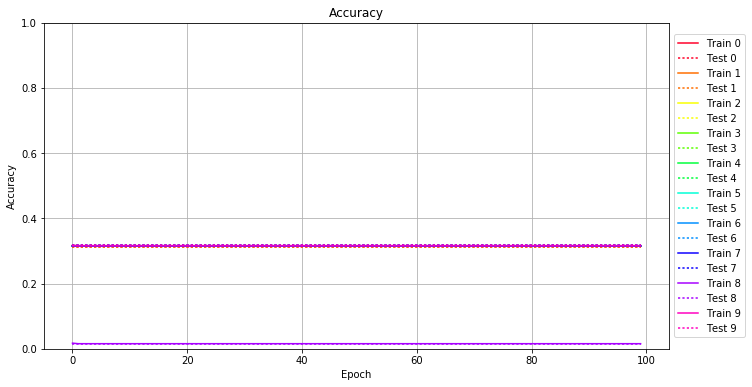

In [13]:
plot_acc(history)

In [14]:
def plot_loss(history):
    figure = plt.gcf()
    figure.set_size_inches(14, 6)
    ax = plt.subplot()
    plt.title('Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    colors = iter(colormap.gist_rainbow(np.linspace(0, 1, len(history))))
    for i in range(len(history)):
        color=next(colors)
        plt.plot(history[i].history['loss'], label='Train '+str(i), color=color, linestyle = 'solid')
        plt.plot(history[i].history['val_loss'], label='Test '+str(i), color=color, linestyle = 'dotted')
    plt.legend()
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.grid(True)
    plt.show()

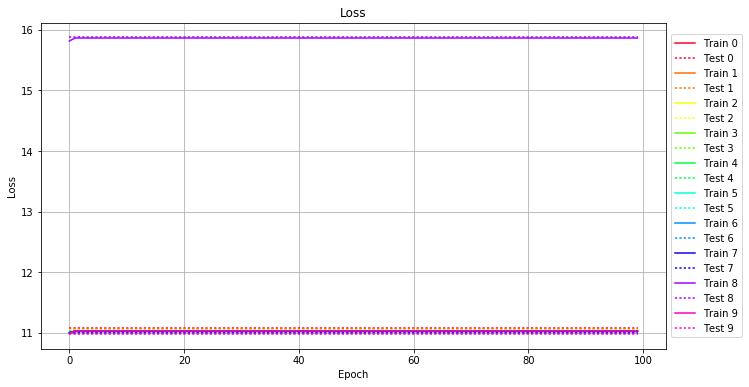

In [15]:
plot_loss(history)

Plotting the confusion matrix


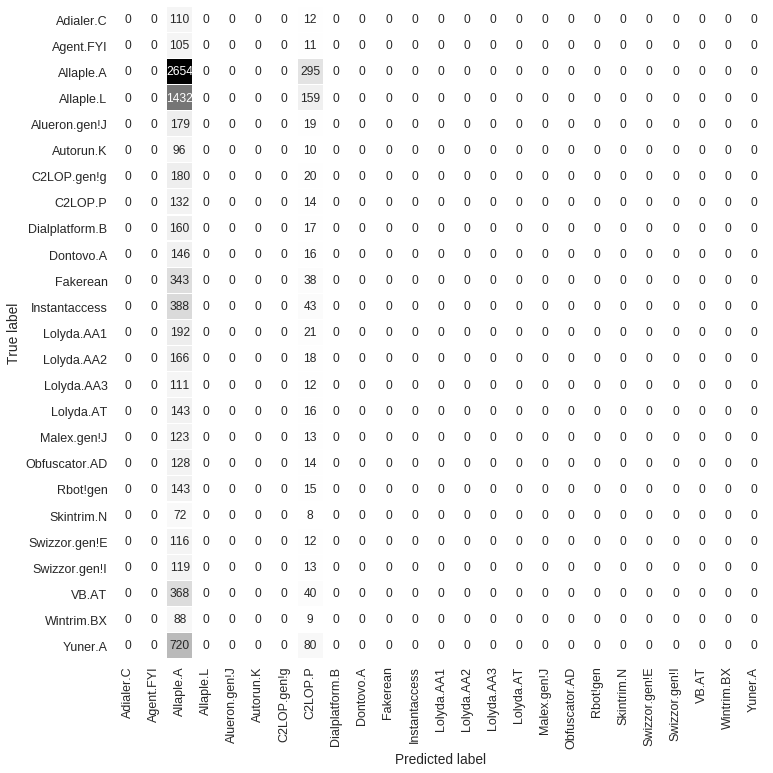

In [16]:
import seaborn as sns

print("Plotting the confusion matrix")
figure = plt.gcf()
figure.set_size_inches(16, 12)
sns.set(font_scale=1.25)
hm = sns.heatmap(conf_mat, cbar=False, annot=True, square=True,
                 fmt='.0f', annot_kws={'size': 12}, linewidth = 0.2, cmap = 'binary',
                 yticklabels=list_fams, xticklabels=list_fams)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

Plotting the confusion matrix normalized


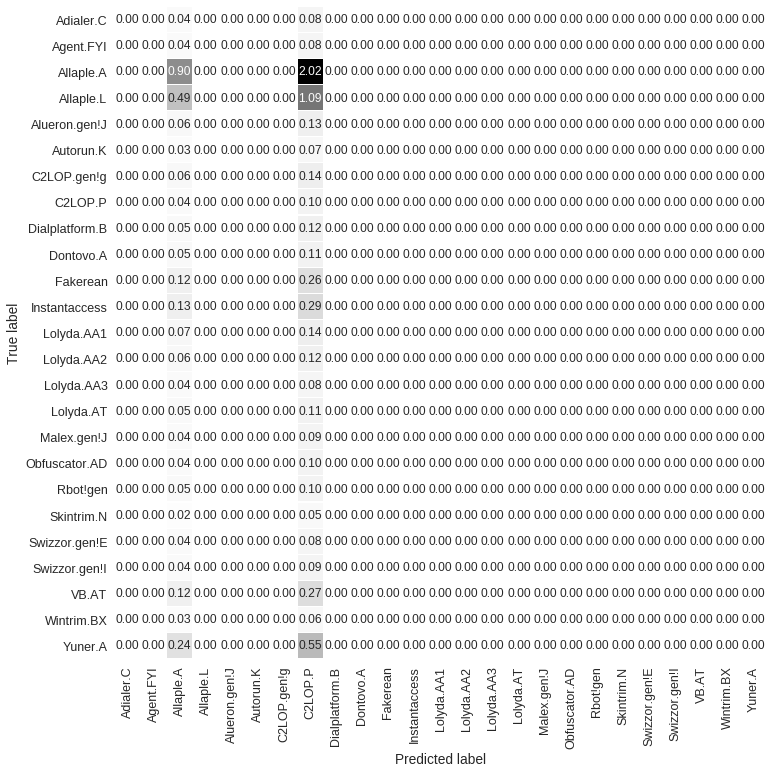

In [17]:
print("Plotting the confusion matrix normalized")
conf_mat_norm = conf_mat/np.sum(conf_mat,axis=1)  # Normalizing the confusion matrix
conf_mat_norm = np.around(conf_mat_norm,decimals=2)  # rounding to display in figure

figure = plt.gcf()
figure.set_size_inches(16, 12)
sns.set(font_scale=1.25)
hm = sns.heatmap(conf_mat_norm, cbar=False, annot=True, square=True,
                 fmt='.2f', annot_kws={'size': 12}, linewidth = 0.1, cmap = 'binary',
                 yticklabels=list_fams, xticklabels=list_fams)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [18]:
for h in history:
    print(h.history)

{'acc': [0.31713128425065523, 0.31617822254701033, 0.3161782225434599, 0.31617822256831291, 0.31617822253990946, 0.31617822254168465, 0.31617822255411121, 0.31617822254701033, 0.31617822255411121, 0.31617822254701033, 0.31617822255411121, 0.31617822255411121, 0.31617822254168465, 0.31617822255411121, 0.31617822255411121, 0.31617822255411121, 0.31617822256831291, 0.31617822255411121, 0.31617822254701033, 0.31617822254168465, 0.31617822253990946, 0.31617822254701033, 0.31617822254701033, 0.31617822254701033, 0.31617822254701033, 0.31617822254168465, 0.31617822255411121, 0.3161782225434599, 0.3161782225434599, 0.31617822255411121, 0.3161782225434599, 0.31617822255411121, 0.31617822254701033, 0.3161782225434599, 0.31617822255411121, 0.31617822256831291, 0.3161782225434599, 0.31617822255411121, 0.3161782225434599, 0.31617822254701033, 0.31617822254701033, 0.31617822255411121, 0.31617822254701033, 0.31617822253990946, 0.3161782225434599, 0.31617822256831291, 0.31617822254701033, 0.3161782225

In [19]:
import matplotlib.ticker as ticker
plt.style.use('seaborn-whitegrid')

def plot_mean_acc(history):
    train_scores = np.zeros((len(history),len(history[0].history['acc'])))
    for fold in range(len(history)):
        train_scores[fold] = history[fold].history['acc']
    test_scores = np.zeros((len(history),len(history[0].history['val_acc'])))
    for fold in range(len(history)):
        test_scores[fold] = history[fold].history['val_acc']
    epochs = np.linspace(0, len(history[0].history['acc']), len(history[0].history['acc']))
    train_scores_mean = np.mean(train_scores, axis=0)
    train_scores_std = np.std(train_scores, axis=0)
    test_scores_mean = np.mean(test_scores, axis=0)
    test_scores_std = np.std(test_scores, axis=0)
    
    figsize=(14, 6)
    text_fontsize="medium"
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax.set_xlabel("Epoch", fontsize=text_fontsize)
    ax.set_ylabel("Score", fontsize=text_fontsize)
    ax.grid(True)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(0.1))
    ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
    ax.fill_between(epochs, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1, color="r")
    ax.fill_between(epochs, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color="g")
    ax.plot(epochs, train_scores_mean, '-', color="r", linewidth=2.0, label="Train")
    ax.plot(epochs, test_scores_mean, '-', color="g", linewidth=2.0, label="Test")
    ax.tick_params(labelsize=text_fontsize)
    ax.legend(loc="best", fontsize=text_fontsize)
    x1,x2,y1,y2 = plt.axis()
    plt.axis((x1,x2,0.0,1.0))
    plt.show()

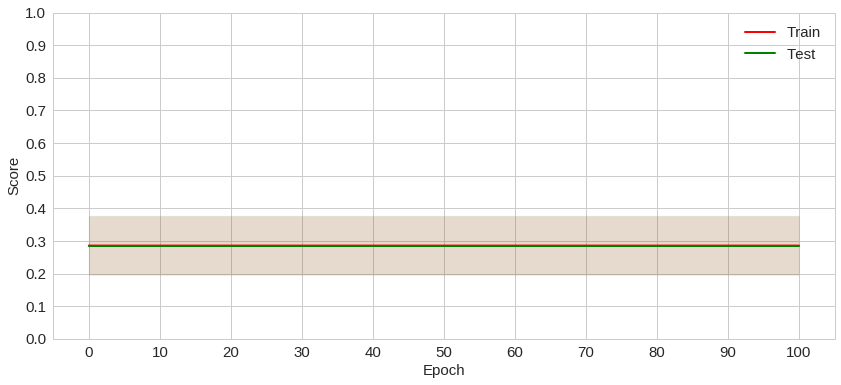

In [20]:
plot_mean_acc(history)

In [21]:
import matplotlib.ticker as ticker
plt.style.use('seaborn-whitegrid')

def plot_mean_loss(history):
    train_scores = np.zeros((len(history),len(history[0].history['loss'])))
    for fold in range(len(history)):
        train_scores[fold] = history[fold].history['loss']
    test_scores = np.zeros((len(history),len(history[0].history['val_loss'])))
    for fold in range(len(history)):
        test_scores[fold] = history[fold].history['val_loss']
    epochs = np.linspace(0, len(history[0].history['loss']), len(history[0].history['loss']))
    train_scores_mean = np.mean(train_scores, axis=0)
    train_scores_std = np.std(train_scores, axis=0)
    test_scores_mean = np.mean(test_scores, axis=0)
    test_scores_std = np.std(test_scores, axis=0)
    
    figsize=(14, 6)
    text_fontsize="medium"
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax.set_xlabel("Epoch", fontsize=text_fontsize)
    ax.set_ylabel("Score", fontsize=text_fontsize)
    ax.grid(True)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
    ax.fill_between(epochs, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1, color="r")
    ax.fill_between(epochs, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color="g")
    ax.plot(epochs, train_scores_mean, '-', color="r", linewidth=2.0, label="Train")
    ax.plot(epochs, test_scores_mean, '-', color="g", linewidth=2.0, label="Test")
    ax.tick_params(labelsize=text_fontsize)
    ax.legend(loc="best", fontsize=text_fontsize)
    plt.show()

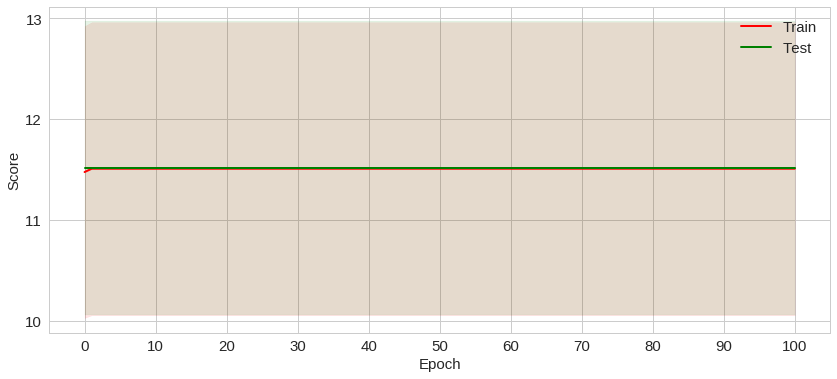

In [22]:
plot_mean_loss(history)

In [24]:
hist = [{'acc': [0.31713128425065523, 0.31617822254701033, 0.3161782225434599, 0.31617822256831291, 0.31617822253990946, 0.31617822254168465, 0.31617822255411121, 0.31617822254701033, 0.31617822255411121, 0.31617822254701033, 0.31617822255411121, 0.31617822255411121, 0.31617822254168465, 0.31617822255411121, 0.31617822255411121, 0.31617822255411121, 0.31617822256831291, 0.31617822255411121, 0.31617822254701033, 0.31617822254168465, 0.31617822253990946, 0.31617822254701033, 0.31617822254701033, 0.31617822254701033, 0.31617822254701033, 0.31617822254168465, 0.31617822255411121, 0.3161782225434599, 0.3161782225434599, 0.31617822255411121, 0.3161782225434599, 0.31617822255411121, 0.31617822254701033, 0.3161782225434599, 0.31617822255411121, 0.31617822256831291, 0.3161782225434599, 0.31617822255411121, 0.3161782225434599, 0.31617822254701033, 0.31617822254701033, 0.31617822255411121, 0.31617822254701033, 0.31617822253990946, 0.3161782225434599, 0.31617822256831291, 0.31617822254701033, 0.31617822253990946, 0.31617822255411121, 0.31617822254168465, 0.31617822255411121, 0.31617822254168465, 0.31617822255411121, 0.3161782225434599, 0.31617822253990946, 0.31617822255411121, 0.31617822255411121, 0.31617822254701033, 0.3161782225434599, 0.3161782225434599, 0.31617822254701033, 0.3161782225434599, 0.31617822255411121, 0.31617822254701033, 0.31617822255411121, 0.31617822255411121, 0.31617822254701033, 0.31617822253990946, 0.31617822254168465, 0.31617822254168465, 0.31617822254701033, 0.31617822256831291, 0.3161782225434599, 0.31617822253990946, 0.31617822255411121, 0.31617822255411121, 0.31617822253990946, 0.31617822255411121, 0.31617822255411121, 0.31617822253990946, 0.31617822253990946, 0.31617822253990946, 0.31617822256831291, 0.31617822254701033, 0.3161782225434599, 0.31617822255411121, 0.31617822255411121, 0.31617822255411121, 0.31617822254701033, 0.31617822254701033, 0.3161782225434599, 0.3161782225434599, 0.31617822255411121, 0.31617822255411121, 0.31617822254168465, 0.31617822253990946, 0.31617822256831291, 0.31617822254701033, 0.31617822253990946, 0.31617822254168465], 'loss': [10.981253960486505, 11.021904599078644, 11.021904640206843, 11.021904608281362, 11.021904624300909, 11.021904567948461, 11.021904605668245, 11.021904635435064, 11.02190463475338, 11.02190459180736, 11.021904605668245, 11.021904591125677, 11.021904626118731, 11.021904605668245, 11.021904591125677, 11.021904569311825, 11.021904586467512, 11.021904663838516, 11.02190462816378, 11.021904604304879, 11.02190466520188, 11.021904617256853, 11.02190464997763, 11.02190464997763, 11.02190462816378, 11.02190460794052, 11.021904620210812, 11.021904582036573, 11.021904575901427, 11.021904591125677, 11.021904546816291, 11.021904583854393, 11.021904599078644, 11.021904603850423, 11.021904547497975, 11.02190462282393, 11.021904662020695, 11.021904642024664, 11.021904589307857, 11.021904599078644, 11.021904606349928, 11.021904576583109, 11.021904599078644, 11.021904687015732, 11.021904648614266, 11.02190456465366, 11.021904620892496, 11.021904624300909, 11.021904591750554, 11.021904684289002, 11.021904569311825, 11.021904582491027, 11.02190463475338, 11.021904619529129, 11.021904628845462, 11.021904627482096, 11.021904576583109, 11.021904664520198, 11.021904626800413, 11.021904597715277, 11.021904664520198, 11.021904625664275, 11.021904598396961, 11.021904620892496, 11.021904631117739, 11.021904532955407, 11.021904533637089, 11.021904636116746, 11.021904633390015, 11.021904611576163, 11.021904599078644, 11.021904601010078, 11.021904634071698, 11.021904628845462, 11.021904642024664, 11.021904656567232, 11.021904534318773, 11.021904569311825, 11.021904685652366, 11.021904679744448, 11.021904577946476, 11.021904636116746, 11.021904608281362, 11.021904562722225, 11.021904574765289, 11.021904576583109, 11.021904576583109, 11.021904576583109, 11.021904620892496, 11.021904588171719, 11.021904575901427, 11.021904626800413, 11.021904576583109, 11.021904649295948, 11.021904611576163, 11.021904628845462, 11.021904644637782, 11.021904613621212, 11.02190464338803, 11.021904618847447], 'val_acc': [0.31216931216931215, 0.31216931216931215, 0.31216931216931215, 0.31216931216931215, 0.31216931216931215, 0.31216931216931215, 0.31216931216931215, 0.31216931216931215, 0.31216931216931215, 0.31216931216931215, 0.31216931216931215, 0.31216931216931215, 0.31216931216931215, 0.31216931216931215, 0.31216931216931215, 0.31216931216931215, 0.31216931216931215, 0.31216931216931215, 0.31216931216931215, 0.31216931216931215, 0.31216931216931215, 0.31216931216931215, 0.31216931216931215, 0.31216931216931215, 0.31216931216931215, 0.31216931216931215, 0.31216931216931215, 0.31216931216931215, 0.31216931216931215, 0.31216931216931215, 0.31216931216931215, 0.31216931216931215, 0.31216931216931215, 0.31216931216931215, 0.31216931216931215, 0.31216931216931215, 0.31216931216931215, 0.31216931216931215, 0.31216931216931215, 0.31216931216931215, 0.31216931216931215, 0.31216931216931215, 0.31216931216931215, 0.31216931216931215, 0.31216931216931215, 0.31216931216931215, 0.31216931216931215, 0.31216931216931215, 0.31216931216931215, 0.31216931216931215, 0.31216931216931215, 0.31216931216931215, 0.31216931216931215, 0.31216931216931215, 0.31216931216931215, 0.31216931216931215, 0.31216931216931215, 0.31216931216931215, 0.31216931216931215, 0.31216931216931215, 0.31216931216931215, 0.31216931216931215, 0.31216931216931215, 0.31216931216931215, 0.31216931216931215, 0.31216931216931215, 0.31216931216931215, 0.31216931216931215, 0.31216931216931215, 0.31216931216931215, 0.31216931216931215, 0.31216931216931215, 0.31216931216931215, 0.31216931216931215, 0.31216931216931215, 0.31216931216931215, 0.31216931216931215, 0.31216931216931215, 0.31216931216931215, 0.31216931216931215, 0.31216931216931215, 0.31216931216931215, 0.31216931216931215, 0.31216931216931215, 0.31216931216931215, 0.31216931216931215, 0.31216931216931215, 0.31216931216931215, 0.31216931216931215, 0.31216931216931215, 0.31216931216931215, 0.31216931216931215, 0.31216931216931215, 0.31216931216931215, 0.31216931216931215, 0.31216931216931215, 0.31216931216931215, 0.31216931216931215, 0.31216931216931215, 0.31216931216931215], 'val_loss': [11.086520684459225, 11.086520684459225, 11.086520684459225, 11.086520684459225, 11.086520684459225, 11.086520684459225, 11.086520684459225, 11.086520684459225, 11.086520684459225, 11.086520684459225, 11.086520684459225, 11.086520684459225, 11.086520684459225, 11.086520684459225, 11.086520684459225, 11.086520684459225, 11.086520684459225, 11.086520684459225, 11.086520684459225, 11.086520684459225, 11.086520684459225, 11.086520684459225, 11.086520684459225, 11.086520684459225, 11.086520684459225, 11.086520684459225, 11.086520684459225, 11.086520684459225, 11.086520684459225, 11.086520684459225, 11.086520684459225, 11.086520684459225, 11.086520684459225, 11.086520684459225, 11.086520684459225, 11.086520684459225, 11.086520684459225, 11.086520684459225, 11.086520684459225, 11.086520684459225, 11.086520684459225, 11.086520684459225, 11.086520684459225, 11.086520684459225, 11.086520684459225, 11.086520684459225, 11.086520684459225, 11.086520684459225, 11.086520684459225, 11.086520684459225, 11.086520684459225, 11.086520684459225, 11.086520684459225, 11.086520684459225, 11.086520684459225, 11.086520684459225, 11.086520684459225, 11.086520684459225, 11.086520684459225, 11.086520684459225, 11.086520684459225, 11.086520684459225, 11.086520684459225, 11.086520684459225, 11.086520684459225, 11.086520684459225, 11.086520684459225, 11.086520684459225, 11.086520684459225, 11.086520684459225, 11.086520684459225, 11.086520684459225, 11.086520684459225, 11.086520684459225, 11.086520684459225, 11.086520684459225, 11.086520684459225, 11.086520684459225, 11.086520684459225, 11.086520684459225, 11.086520684459225, 11.086520684459225, 11.086520684459225, 11.086520684459225, 11.086520684459225, 11.086520684459225, 11.086520684459225, 11.086520684459225, 11.086520684459225, 11.086520684459225, 11.086520684459225, 11.086520684459225, 11.086520684459225, 11.086520684459225, 11.086520684459225, 11.086520684459225, 11.086520684459225, 11.086520684459225, 11.086520684459225, 11.086520684459225]},
{'acc': [0.31546981070344615, 0.3160652614206278, 0.31606526145257025, 0.3160652614206278, 0.31606526140731844, 0.3160652614206278, 0.31606526141175489, 0.31606526142772612, 0.31606526143127528, 0.3160652614206278, 0.31606526142772612, 0.31606526142772612, 0.3160652614206278, 0.31606526145966857, 0.3160652614206278, 0.31606526141175489, 0.3160652614206278, 0.31606526142772612, 0.31606526144547192, 0.31606526145966857, 0.3160652614206278, 0.3160652614206278, 0.31606526141352947, 0.31606526141175489, 0.31606526142772612, 0.31606526142772612, 0.31606526145966857, 0.31606526140288199, 0.31606526145966857, 0.3160652614206278, 0.31606526142772612, 0.3160652614206278, 0.31606526144547192, 0.31606526142772612, 0.31606526145257025, 0.31606526142772612, 0.31606526145257025, 0.31606526145966857, 0.31606526142772612, 0.3160652614206278, 0.3160652614206278, 0.3160652614206278, 0.31606526144547192, 0.31606526142772612, 0.3160652614206278, 0.3160652614206278, 0.31606526142772612, 0.31606526145966857, 0.31606526144547192, 0.3160652614206278, 0.31606526153065184, 0.31606526142772612, 0.31606526142772612, 0.3160652614206278, 0.31606526142772612, 0.3160652614206278, 0.31606526141352947, 0.3160652614206278, 0.31606526140731844, 0.31606526141175489, 0.3160652614206278, 0.3160652614383736, 0.31606526144547192, 0.31606526145257025, 0.31606526145966857, 0.31606526141352947, 0.3160652614206278, 0.3160652614206278, 0.31606526144547192, 0.3160652614206278, 0.31606526141175489, 0.3160652614206278, 0.31606526144547192, 0.3160652614383736, 0.3160652614206278, 0.31606526140731844, 0.31606526141175489, 0.31606526142772612, 0.31606526140731844, 0.31606526141175489, 0.3160652614206278, 0.31606526145257025, 0.3160652614206278, 0.31606526145257025, 0.31606526141175489, 0.31606526142772612, 0.31606526141352947, 0.31606526145966857, 0.3160652614206278, 0.31606526145966857, 0.31606526142772612, 0.3160652614206278, 0.3160652614206278, 0.31606526145257025, 0.31606526140731844, 0.3160652614206278, 0.31606526141175489, 0.3160652614206278, 0.31606526145966857, 0.31606526141175489], 'loss': [10.994263814803716, 11.023725383350136, 11.023725311344714, 11.023725361544077, 11.023725306688213, 11.023725332469335, 11.023725321566305, 11.023725323383477, 11.023725263700749, 11.023725317931962, 11.023725421510736, 11.023725381532964, 11.023725332469335, 11.023725252854508, 11.023725317931962, 11.023725343372362, 11.023725376081449, 11.023725396070336, 11.023725305893201, 11.023725325541367, 11.02372530339459, 11.023725317931962, 11.023725289197937, 11.023725293968013, 11.023725359726907, 11.023725294308733, 11.023725347347426, 11.023725342690923, 11.023725369153484, 11.023725317931962, 11.023725374264279, 11.023725376081449, 11.023725334967944, 11.02372535245822, 11.023725267732599, 11.02372531611479, 11.023725304076029, 11.023725289197937, 11.023725337920848, 11.023725296125903, 11.023725354275392, 11.023725357909735, 11.023725313161886, 11.023725381532964, 11.023725390618822, 11.02372533973802, 11.023725388801649, 11.023725311003995, 11.023725327699259, 11.023725347006705, 11.023725364383408, 11.023725374264279, 11.023725381532964, 11.02372533973802, 11.023725345189535, 11.023725357909735, 11.023725332810054, 11.02372533973802, 11.023725395388897, 11.02372538846093, 11.023725361544077, 11.023725422532896, 11.023725342236631, 11.02372541310632, 11.023725318272682, 11.02372530373531, 11.023725332469335, 11.023725360067626, 11.023725284087142, 11.023725354275392, 11.0237253521175, 11.023725325200648, 11.023725371311375, 11.023725313502606, 11.023725332469335, 11.023725315433351, 11.023725343372362, 11.02372531611479, 11.023725357569015, 11.023725336103677, 11.023725354275392, 11.023725260463912, 11.02372530339459, 11.023725347688146, 11.023725344848815, 11.023725366995592, 11.023725340078739, 11.023725347347426, 11.023725317931962, 11.023725354616111, 11.023725294308733, 11.023725390618822, 11.023725347006705, 11.02372539130026, 11.023725308164664, 11.02372530339459, 11.023725221281152, 11.023725230707729, 11.023725281929252, 11.023725279430641], 'val_acc': [0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086], 'val_loss': [11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856]},
{'acc': [0.31591477206868368, 0.31591477207577862, 0.31591477206868368, 0.31591477205272006, 0.31591477206158874, 0.31591477205272006, 0.31591477207577862, 0.31591477211480085, 0.31591477207577862, 0.31591477207577862, 0.31591477205449381, 0.31591477205272006, 0.31591477205138974, 0.31591477205183316, 0.31591477206868368, 0.31591477206868368, 0.31591477207577862, 0.31591477207577862, 0.31591477207577862, 0.31591477206868368, 0.31591477207577862, 0.315914772059815, 0.31591477206158874, 0.31591477205272006, 0.31591477206868368, 0.31591477205272006, 0.31591477207577862, 0.31591477206158874, 0.31591477205272006, 0.31591477210770591, 0.31591477210770591, 0.31591477207577862, 0.31591477206868368, 0.31591477211480085, 0.31591477207577862, 0.31591477210770591, 0.31591477205272006, 0.31591477206868368, 0.31591477206868368, 0.31591477211480085, 0.31591477206158874, 0.31591477207577862, 0.31591477205272006, 0.31591477207577862, 0.31591477206868368, 0.31591477205183316, 0.31591477210061092, 0.31591477206868368, 0.31591477206868368, 0.315914772059815, 0.31591477205272006, 0.31591477211480085, 0.31591477206158874, 0.31591477209351598, 0.31591477206868368, 0.315914772059815, 0.31591477210061092, 0.31591477210770591, 0.31591477206868368, 0.315914772059815, 0.31591477206868368, 0.315914772059815, 0.31591477205272006, 0.31591477206868368, 0.31591477205183316, 0.31591477205272006, 0.31591477207577862, 0.31591477207577862, 0.31591477207577862, 0.31591477206158874, 0.31591477206868368, 0.315914772059815, 0.31591477207577862, 0.31591477211480085, 0.31591477206868368, 0.31591477205138974, 0.31591477207577862, 0.315914772059815, 0.31591477206868368, 0.31591477206868368, 0.315914772059815, 0.31591477206868368, 0.31591477206868368, 0.31591477210770591, 0.31591477206868368, 0.315914772059815, 0.31591477206868368, 0.31591477207577862, 0.315914772059815, 0.31591477207577862, 0.31591477206158874, 0.31591477207577862, 0.31591477206868368, 0.31591477205272006, 0.31591477205272006, 0.31591477206158874, 0.31591477206868368, 0.31591477206158874, 0.31591477209351598, 0.31591477206868368], 'loss': [10.994297921210581, 11.026150920819333, 11.026150949426158, 11.02615092660881, 11.026150907310555, 11.026150890282684, 11.026150935349785, 11.026150930581981, 11.026150920819333, 11.026150993471585, 11.026150966908105, 11.02615095566971, 11.026150938641839, 11.026150925587137, 11.026150891304356, 11.026150913100032, 11.026150957145459, 11.026150891758434, 11.026150906288883, 11.026150913100032, 11.026150942615009, 11.026150939663511, 11.026150929106231, 11.026150948404485, 11.026150931263095, 11.026150962934935, 11.026150906288883, 11.026150950901906, 11.026150984730611, 11.026150931092817, 11.026150931092817, 11.02615100073681, 11.026150920365257, 11.026150966908105, 11.026150949880234, 11.026150960153716, 11.026150904813134, 11.026150949426158, 11.026150905834808, 11.026150930581981, 11.026150936371456, 11.026150935349785, 11.026150912078359, 11.026150906288883, 11.026150876773906, 11.026150925587137, 11.026150953399327, 11.026150905834808, 11.026150971221833, 11.026150932398286, 11.02615092660881, 11.026150937847206, 11.026150958167131, 11.026150994833815, 11.026150927630482, 11.026150932398286, 11.026150909807978, 11.026150876603628, 11.026150927630482, 11.026150925133061, 11.026150963956608, 11.026150903337387, 11.026150991995836, 11.026150905834808, 11.026150969178488, 11.026150948404485, 11.026150891758434, 11.026150978941134, 11.026150906288883, 11.026150936371456, 11.026150891304356, 11.026150990520087, 11.02615098620636, 11.026150930581981, 11.026150942160932, 11.026150953172289, 11.026150993471585, 11.026150932398286, 11.026151007547959, 11.026150898569583, 11.026150903337387, 11.026150920365257, 11.026151000282734, 11.026150923827592, 11.026150934895707, 11.026150946928736, 11.02615084044778, 11.026150978941134, 11.02615089607216, 11.026150906288883, 11.026150936371456, 11.026150877227982, 11.026150949426158, 11.026150853956558, 11.026150912078359, 11.026150907310555, 11.026150884039131, 11.026150929106231, 11.026150962140301, 11.026150884039131], 'val_acc': [0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896], 'val_loss': [11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498]},
{'acc': [0.31619659646074078, 0.31583958110553401, 0.31583958107361437, 0.31583958110287402, 0.3158395811410003, 0.31583958110553401, 0.31583958115873345, 0.31583958112326715, 0.31583958114454691, 0.31583958110908067, 0.31583958109134752, 0.31583958110908067, 0.31583958110908067, 0.31583958110553401, 0.31583958109134752, 0.31583958110553401, 0.31583958110553401, 0.31583958107361437, 0.31583958109134752, 0.31583958110553401, 0.31583958112326715, 0.31583958108780086, 0.31583958107361437, 0.31583958107361437, 0.31583958110908067, 0.31583958110553401, 0.31583958115873345, 0.31583958112326715, 0.31583958110553401, 0.3158395811037607, 0.31583958109134752, 0.31583958114454691, 0.31583958112326715, 0.3158395811037607, 0.31583958115873345, 0.31583958115873345, 0.31583958108780086, 0.31583958112326715, 0.31583958112326715, 0.3158395811037607, 0.31583958109134752, 0.31583958112681376, 0.31583958112326715, 0.31583958109134752, 0.31583958109134752, 0.31583958110908067, 0.31583958107361437, 0.31583958110553401, 0.31583958107361437, 0.31583958115873345, 0.31583958109134752, 0.31583958107361437, 0.31583958112326715, 0.31583958110908067, 0.31583958112326715, 0.31583958112326715, 0.31583958112326715, 0.31583958112326715, 0.31583958110908067, 0.3158395811410003, 0.31583958112326715, 0.31583958114454691, 0.3158395811410003, 0.31583958107361437, 0.31583958105942783, 0.31583958114454691, 0.31583958114454691, 0.31583958110908067, 0.31583958108780086, 0.31583958115873345, 0.31583958110553401, 0.31583958109134752, 0.31583958110908067, 0.31583958112326715, 0.31583958114454691, 0.31583958122966604, 0.31583958109134752, 0.31583958107361437, 0.31583958110908067, 0.31583958112326715, 0.31583958115873345, 0.31583958112326715, 0.31583958107361437, 0.31583958110553401, 0.31583958115873345, 0.31583958115873345, 0.31583958107361437, 0.31583958114454691, 0.3158395811764666, 0.31583958112326715, 0.31583958112326715, 0.31583958110908067, 0.31583958110908067, 0.31583958112326715, 0.31583958115873345, 0.31583958109134752, 0.31583958107361437, 0.31583958112326715, 0.31583958112326715, 0.31583958110553401], 'loss': [10.994979964400081, 11.027362903384784, 11.027362906676055, 11.027362814520451, 11.027362899412559, 11.027362905541134, 11.027362856399044, 11.027362887949854, 11.027362880970088, 11.027362860598252, 11.027362914507011, 11.027362856966505, 11.027362856966505, 11.027362881594296, 11.027362907243516, 11.027362898277637, 11.027362859803807, 11.027362846411737, 11.027362856399044, 11.027362917911775, 11.027362855264123, 11.027362854129201, 11.027362783196624, 11.027362906676055, 11.027362922337968, 11.02736289248954, 11.027362856399044, 11.027362913372091, 11.027362811115687, 11.027362884091122, 11.027362791027581, 11.027362902760576, 11.027362927899082, 11.027362880459375, 11.027362907243516, 11.027362856399044, 11.027362897710177, 11.027362811683147, 11.027362818946644, 11.027362822351407, 11.027362856399044, 11.027362850270469, 11.027362891581602, 11.027362874557785, 11.027362881821279, 11.027362909967326, 11.027362921203046, 11.027362898277637, 11.02736286525143, 11.027362892716523, 11.02736289998002, 11.027362884885568, 11.02736287705461, 11.02736290270383, 11.027362855264123, 11.027362840737132, 11.027362927899082, 11.027362862527619, 11.027362909967326, 11.027362921203046, 11.027362818946644, 11.027362874784767, 11.027362855831583, 11.027362921203046, 11.02736286479746, 11.027362837389113, 11.027362830125618, 11.027362837332367, 11.027362897710177, 11.027362929034004, 11.027362891014143, 11.027362870926035, 11.027362842439512, 11.027362848000626, 11.0273628591796, 11.0273629261967, 11.02736289998002, 11.027362921203046, 11.027362907810977, 11.027362898845098, 11.027362805554572, 11.027362862527619, 11.02736286309508, 11.027362825642678, 11.027362914507011, 11.027362885453028, 11.027362877622071, 11.027362902760576, 11.027362871493496, 11.02736287705461, 11.027362906108594, 11.027362915074471, 11.027362893283984, 11.027362906108594, 11.027362914507011, 11.02736289998002, 11.027362877622071, 11.027362811683147, 11.027362862527619, 11.027362859803807], 'val_acc': [0.31517094017094016, 0.31517094017094016, 0.31517094017094016, 0.31517094017094016, 0.31517094017094016, 0.31517094017094016, 0.31517094017094016, 0.31517094017094016, 0.31517094017094016, 0.31517094017094016, 0.31517094017094016, 0.31517094017094016, 0.31517094017094016, 0.31517094017094016, 0.31517094017094016, 0.31517094017094016, 0.31517094017094016, 0.31517094017094016, 0.31517094017094016, 0.31517094017094016, 0.31517094017094016, 0.31517094017094016, 0.31517094017094016, 0.31517094017094016, 0.31517094017094016, 0.31517094017094016, 0.31517094017094016, 0.31517094017094016, 0.31517094017094016, 0.31517094017094016, 0.31517094017094016, 0.31517094017094016, 0.31517094017094016, 0.31517094017094016, 0.31517094017094016, 0.31517094017094016, 0.31517094017094016, 0.31517094017094016, 0.31517094017094016, 0.31517094017094016, 0.31517094017094016, 0.31517094017094016, 0.31517094017094016, 0.31517094017094016, 0.31517094017094016, 0.31517094017094016, 0.31517094017094016, 0.31517094017094016, 0.31517094017094016, 0.31517094017094016, 0.31517094017094016, 0.31517094017094016, 0.31517094017094016, 0.31517094017094016, 0.31517094017094016, 0.31517094017094016, 0.31517094017094016, 0.31517094017094016, 0.31517094017094016, 0.31517094017094016, 0.31517094017094016, 0.31517094017094016, 0.31517094017094016, 0.31517094017094016, 0.31517094017094016, 0.31517094017094016, 0.31517094017094016, 0.31517094017094016, 0.31517094017094016, 0.31517094017094016, 0.31517094017094016, 0.31517094017094016, 0.31517094017094016, 0.31517094017094016, 0.31517094017094016, 0.31517094017094016, 0.31517094017094016, 0.31517094017094016, 0.31517094017094016, 0.31517094017094016, 0.31517094017094016, 0.31517094017094016, 0.31517094017094016, 0.31517094017094016, 0.31517094017094016, 0.31517094017094016, 0.31517094017094016, 0.31517094017094016, 0.31517094017094016, 0.31517094017094016, 0.31517094017094016, 0.31517094017094016, 0.31517094017094016, 0.31517094017094016, 0.31517094017094016, 0.31517094017094016, 0.31517094017094016, 0.31517094017094016, 0.31517094017094016, 0.31517094017094016], 'val_loss': [11.038140150216913, 11.038140150216913, 11.038140150216913, 11.038140150216913, 11.038140150216913, 11.038140150216913, 11.038140150216913, 11.038140150216913, 11.038140150216913, 11.038140150216913, 11.038140150216913, 11.038140150216913, 11.038140150216913, 11.038140150216913, 11.038140150216913, 11.038140150216913, 11.038140150216913, 11.038140150216913, 11.038140150216913, 11.038140150216913, 11.038140150216913, 11.038140150216913, 11.038140150216913, 11.038140150216913, 11.038140150216913, 11.038140150216913, 11.038140150216913, 11.038140150216913, 11.038140150216913, 11.038140150216913, 11.038140150216913, 11.038140150216913, 11.038140150216913, 11.038140150216913, 11.038140150216913, 11.038140150216913, 11.038140150216913, 11.038140150216913, 11.038140150216913, 11.038140150216913, 11.038140150216913, 11.038140150216913, 11.038140150216913, 11.038140150216913, 11.038140150216913, 11.038140150216913, 11.038140150216913, 11.038140150216913, 11.038140150216913, 11.038140150216913, 11.038140150216913, 11.038140150216913, 11.038140150216913, 11.038140150216913, 11.038140150216913, 11.038140150216913, 11.038140150216913, 11.038140150216913, 11.038140150216913, 11.038140150216913, 11.038140150216913, 11.038140150216913, 11.038140150216913, 11.038140150216913, 11.038140150216913, 11.038140150216913, 11.038140150216913, 11.038140150216913, 11.038140150216913, 11.038140150216913, 11.038140150216913, 11.038140150216913, 11.038140150216913, 11.038140150216913, 11.038140150216913, 11.038140150216913, 11.038140150216913, 11.038140150216913, 11.038140150216913, 11.038140150216913, 11.038140150216913, 11.038140150216913, 11.038140150216913, 11.038140150216913, 11.038140150216913, 11.038140150216913, 11.038140150216913, 11.038140150216913, 11.038140150216913, 11.038140150216913, 11.038140150216913, 11.038140150216913, 11.038140150216913, 11.038140150216913, 11.038140150216913, 11.038140150216913, 11.038140150216913, 11.038140150216913, 11.038140150216913, 11.038140150216913]},
{'acc': [0.31496906236544614, 0.3158019990622572, 0.31580199904807232, 0.31580199904807232, 0.31580199907644202, 0.31580199904807232, 0.31580199910481166, 0.31580199905516476, 0.31580199904807232, 0.31580199904807232, 0.3158019990338875, 0.3158019990622572, 0.3158019990622572, 0.31580199901970268, 0.31580199904807232, 0.3158019990338875, 0.31580199904807232, 0.31580199907644202, 0.31580199907644202, 0.31580199907644202, 0.31580199904807232, 0.31580199904807232, 0.31580199907644202, 0.31580199905516476, 0.31580199907644202, 0.3158019990338875, 0.31580199904807232, 0.31580199910481166, 0.31580199907644202, 0.31580199904807232, 0.31580199909062684, 0.31580199905516476, 0.31580199905516476, 0.31580199907644202, 0.3158019990622572, 0.31580199904807232, 0.3158019990622572, 0.31580199904807232, 0.3158019990622572, 0.3158019991331813, 0.31580199907644202, 0.31580199904807232, 0.3158019990338875, 0.31580199905516476, 0.31580199910481166, 0.31580199901970268, 0.3158019990338875, 0.31580199905516476, 0.31580199904807232, 0.3158019990622572, 0.3158019990622572, 0.31580199907644202, 0.31580199904807232, 0.31580199907644202, 0.31580199904807232, 0.31580199907644202, 0.31580199904807232, 0.31580199910481166, 0.31580199904807232, 0.31580199905516476, 0.31580199905161854, 0.31580199905516476, 0.31580199907644202, 0.31580199910481166, 0.31580199910481166, 0.3158019990622572, 0.31580199907644202, 0.31580199910481166, 0.3158019990622572, 0.31580199910481166, 0.3158019990622572, 0.31580199905516476, 0.3158019990622572, 0.31580199909062684, 0.31580199907644202, 0.31580199910481166, 0.3158019990622572, 0.3158019990622572, 0.31580199901970268, 0.31580199905516476, 0.31580199904807232, 0.31580199907644202, 0.31580199905516476, 0.31580199907644202, 0.3158019990622572, 0.3158019990338875, 0.3158019990338875, 0.31580199910481166, 0.3158019990622572, 0.31580199910481166, 0.3158019990622572, 0.31580199901970268, 0.31580199907644202, 0.31580199910481166, 0.31580199909062684, 0.31580199904807232, 0.31580199907644202, 0.31580199905516476, 0.31580199904807232, 0.31580199910481166], 'loss': [11.011343025468975, 11.027968592328268, 11.027968605945702, 11.027968642258859, 11.027968593236096, 11.027968664046755, 11.027968638627543, 11.027968676756361, 11.027968685834649, 11.027968627733596, 11.027968616839649, 11.027968581434319, 11.027968691735538, 11.027968615931821, 11.027968664046755, 11.027968614570076, 11.027968595959583, 11.027968607761359, 11.027968607761359, 11.027968527872412, 11.027968588696952, 11.027968649521492, 11.027968644074518, 11.027968647705833, 11.027968571448202, 11.027968674940702, 11.027968569632543, 11.027968667678071, 11.027968585973465, 11.027968617747478, 11.027968603676129, 11.027968620924879, 11.02796862818751, 11.027968633180571, 11.027968601860472, 11.027968671309386, 11.027968650429321, 11.027968547844649, 11.027968630910998, 11.027968659961525, 11.027968687650308, 11.027968627733596, 11.02796858052649, 11.027968669493728, 11.027968616839649, 11.027968703083399, 11.027968658145866, 11.027968633180571, 11.027968627733596, 11.027968601860472, 11.027968663592841, 11.027968578710833, 11.027968584157806, 11.027968680387676, 11.027968671309386, 11.027968593236096, 11.027968598683071, 11.027968609577018, 11.027968576895175, 11.027968635450142, 11.027968619563136, 11.027968618655306, 11.027968629549255, 11.027968570994286, 11.027968566001228, 11.027968667224156, 11.027968626825768, 11.027968674940702, 11.027968599590899, 11.027968682203333, 11.027968599590899, 11.027968635450142, 11.027968648159748, 11.027968603676129, 11.027968578710833, 11.027968616839649, 11.027968643166689, 11.027968652698892, 11.027968652244978, 11.027968620924879, 11.027968620470965, 11.027968687650308, 11.027968582342149, 11.027968611392675, 11.027968587335208, 11.027968625464023, 11.027968616839649, 11.027968689465965, 11.027968611846589, 11.027968653152808, 11.027968604583958, 11.027968644982346, 11.027968636811886, 11.027968558738596, 11.027968632726656, 11.027968639535374, 11.027968622286624, 11.02796865859978, 11.027968719424321, 11.027968602314386], 'val_acc': [0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432], 'val_loss': [11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087]},
{'acc': [0.3155640171488826, 0.31580199909062684, 0.31580199905516476, 0.3158019990622572, 0.31580199907644202, 0.31580199907644202, 0.31580199904807232, 0.31580199907644202, 0.31580199905516476, 0.3158019990622572, 0.31580199907644202, 0.3158019990622572, 0.3158019990338875, 0.3158019990622572, 0.3158019990622572, 0.31580199904807232, 0.3158019990622572, 0.31580199904807232, 0.3158019990622572, 0.31580199904807232, 0.3158019990622572, 0.31580199905516476, 0.31580199907644202, 0.3158019990622572, 0.31580199910481166, 0.31580199905516476, 0.31580199910481166, 0.31580199904807232, 0.31580199904807232, 0.31580199904807232, 0.3158019990622572, 0.3158019990622572, 0.31580199907644202, 0.31580199909062684, 0.3158019990338875, 0.31580199904807232, 0.31580199904807232, 0.31580199910481166, 0.31580199905516476, 0.3158019990338875, 0.3158019990622572, 0.31580199904807232, 0.31580199910481166, 0.3158019990338875, 0.3158019990622572, 0.31580199907644202, 0.31580199905161854, 0.31580199904807232, 0.31580199907644202, 0.31580199904807232, 0.31580199907644202, 0.31580199910481166, 0.31580199910481166, 0.3158019990338875, 0.31580199904807232, 0.31580199910481166, 0.31580199907644202, 0.31580199905161854, 0.31580199907644202, 0.3158019990622572, 0.31580199909062684, 0.3158019991331813, 0.31580199904807232, 0.31580199907644202, 0.3158019990622572, 0.31580199901970268, 0.3158019990622572, 0.31580199907644202, 0.31580199905516476, 0.3158019990622572, 0.31580199910481166, 0.31580199899133304, 0.31580199904807232, 0.3158019990622572, 0.31580199905516476, 0.31580199910481166, 0.31580199907644202, 0.3158019990622572, 0.31580199910481166, 0.31580199910481166, 0.31580199904807232, 0.31580199904807232, 0.31580199904807232, 0.31580199907644202, 0.3158019990338875, 0.31580199904807232, 0.31580199907644202, 0.31580199901970268, 0.31580199901970268, 0.31580199907644202, 0.3158019990622572, 0.31580199904807232, 0.31580199910481166, 0.31580199907644202, 0.31580199904807232, 0.3158019990622572, 0.31580199904807232, 0.31580199904807232, 0.31580199904807232, 0.31580199907644202], 'loss': [11.000336952972049, 11.027968632726656, 11.027968618655306, 11.027968652698892, 11.027968626825768, 11.027968593236096, 11.027968707622545, 11.027968636811886, 11.027968625917939, 11.027968616385735, 11.027968600498728, 11.027968674486788, 11.027968573263859, 11.027968667224156, 11.027968536496786, 11.027968617747478, 11.027968575533432, 11.027968584157806, 11.027968616385735, 11.027968598683071, 11.027968659961525, 11.027968577349089, 11.027968583249978, 11.02796864543626, 11.027968638627543, 11.02796858461172, 11.027968660415439, 11.027968667678071, 11.027968671309386, 11.027968700359914, 11.027968630910998, 11.027968521971523, 11.027968629549255, 11.027968632726656, 11.027968636357972, 11.027968569632543, 11.027968603222215, 11.027968616839649, 11.027968599136985, 11.027968602314386, 11.027968548752478, 11.02796869309728, 11.027968558738596, 11.027968621832708, 11.027968594597839, 11.027968629549255, 11.027968583249978, 11.027968591420438, 11.02796861502399, 11.027968555107281, 11.027968600498728, 11.027968616839649, 11.027968624102281, 11.027968660415439, 11.02796858052649, 11.027968660415439, 11.027968665862412, 11.027968619563136, 11.027968644074518, 11.027968674486788, 11.027968596413498, 11.027968638173629, 11.027968642258859, 11.027968636811886, 11.027968652698892, 11.027968652244978, 11.027968616385735, 11.027968673125045, 11.027968610030932, 11.027968621378793, 11.027968602314386, 11.027968613662248, 11.027968634996228, 11.027968640897116, 11.027968602768301, 11.027968558738596, 11.027968636811886, 11.027968638173629, 11.027968551475965, 11.027968616839649, 11.027968642258859, 11.027968664046755, 11.027968613208333, 11.027968702175571, 11.027968551475965, 11.027968613208333, 11.027968625917939, 11.027968615931821, 11.027968623194452, 11.027968564185569, 11.027968669947644, 11.027968642258859, 11.027968674940702, 11.027968702175571, 11.027968627733596, 11.027968640897116, 11.027968634996228, 11.027968639535374, 11.027968562369912, 11.027968680387676], 'val_acc': [0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432], 'val_loss': [11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087]},
{'acc': [0.31517602283539486, 0.3156517602567101, 0.31565176022835395, 0.3156517602567101, 0.3156517602567101, 0.31565176024253205, 0.31565176022835395, 0.31565176022835395, 0.31565176024253205, 0.31565176028506625, 0.31565176028506625, 0.31565176022835395, 0.3156517602567101, 0.3156517602567101, 0.31565176028506625, 0.31565176022835395, 0.3156517602567101, 0.3156517602567101, 0.31565176034177861, 0.3156517602567101, 0.3156517602567101, 0.3156517602567101, 0.31565176022835395, 0.3156517602567101, 0.3156517602567101, 0.31565176028506625, 0.31565176024253205, 0.31565176028506625, 0.31565176022835395, 0.3156517602567101, 0.31565176028506625, 0.31565176028506625, 0.31565176022835395, 0.3156517602567101, 0.3156517603134224, 0.31565176022835395, 0.31565176028506625, 0.31565176028506625, 0.31565176028506625, 0.31565176028506625, 0.31565176024253205, 0.31565176028506625, 0.315651760235443, 0.31565176024253205, 0.31565176028506625, 0.31565176022835395, 0.3156517602567101, 0.31565176022835395, 0.3156517602567101, 0.31565176024253205, 0.3156517602567101, 0.3156517602567101, 0.31565176028506625, 0.31565176024253205, 0.31565176022835395, 0.3156517602567101, 0.3156517602567101, 0.31565176022835395, 0.31565176024253205, 0.3156517601999978, 0.31565176028506625, 0.31565176028506625, 0.31565176028506625, 0.31565176022835395, 0.31565176022835395, 0.3156517602567101, 0.31565176028506625, 0.31565176034177861, 0.3156517602567101, 0.31565176024253205, 0.3156517602567101, 0.31565176028506625, 0.3156517602567101, 0.31565176028506625, 0.31565176022835395, 0.31565176022835395, 0.31565176022835395, 0.3156517602567101, 0.31565176024253205, 0.3156517602567101, 0.31565176022835395, 0.31565176022835395, 0.3156517602567101, 0.31565176022835395, 0.31565176022835395, 0.3156517602567101, 0.31565176022835395, 0.31565176028506625, 0.31565176024253205, 0.31565176022835395, 0.31565176028506625, 0.31565176022835395, 0.31565176022835395, 0.31565176028506625, 0.31565176028506625, 0.31565176028506625, 0.31565176024253205, 0.31565176024253205, 0.31565176022835395, 0.3156517602567101], 'loss': [11.002501289011976, 11.030390125133104, 11.030390192280487, 11.030390239465135, 11.030390195910075, 11.030390126040501, 11.030390264872253, 11.030390199539664, 11.030390118781325, 11.030390237650341, 11.030390165058575, 11.030390204984046, 11.030390210428429, 11.030390212243223, 11.030390157799399, 11.030390168688163, 11.030390139651457, 11.030390149632826, 11.03039019137309, 11.03039019772487, 11.030390188650898, 11.030390190465694, 11.030390185021311, 11.030390164151179, 11.030390168688163, 11.030390194095281, 11.030390220409796, 11.030390175039942, 11.030390163243782, 11.030390137836664, 11.03039013602187, 11.030390196817473, 11.030390155984605, 11.030390166873369, 11.030390260335267, 11.030390103355575, 11.030390186836105, 11.030390182299119, 11.030390157799399, 11.030390157799399, 11.030390133299678, 11.030390244909517, 11.030390226761575, 11.030390205891443, 11.030390225854179, 11.030390231298561, 11.03039014509584, 11.030390167780766, 11.030390130577487, 11.030390169595561, 11.030390130577487, 11.030390159614193, 11.030390157799399, 11.030390162336383, 11.030390158706796, 11.030390217687605, 11.030390183206517, 11.030390202261854, 11.030390162336383, 11.030390186836105, 11.030390201354457, 11.030390193187884, 11.030390244909517, 11.030390146910634, 11.030390137836664, 11.03039014509584, 11.030390196817473, 11.030390220409796, 11.030390212243223, 11.03039021315062, 11.030390253983487, 11.030390116966531, 11.030390195910075, 11.030390165058575, 11.030390146910634, 11.030390185021311, 11.030390141466251, 11.030390152355016, 11.030390176854738, 11.030390183206517, 11.030390226761575, 11.030390209521032, 11.03039014509584, 11.030390148725427, 11.030390226761575, 11.030390217687605, 11.03039015416981, 11.030390194095281, 11.030390155077207, 11.030390155984605, 11.030390114244339, 11.030390151447619, 11.03039015416981, 11.03039013874406, 11.030390114244339, 11.03039025942787, 11.03039019137309, 11.030390184113914, 11.030390112429545, 11.03039022222459], 'val_acc': [0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927], 'val_loss': [11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082]},
{'acc': [0.31557669443976438, 0.31557669443976438, 0.31557669446102649, 0.31557669446102649, 0.31557669444685177, 0.31557669446811382, 0.3155766944539391, 0.31557669443976438, 0.31557669451063791, 0.31557669444685177, 0.3155766944539391, 0.31557669443976438, 0.31557669459568616, 0.31557669446102649, 0.3155766944539391, 0.31557669446102649, 0.3155766945177253, 0.31557669444685177, 0.31557669446102649, 0.31557669460986087, 0.31557669453898735, 0.31557669452481263, 0.31557669452481263, 0.3155766944539391, 0.31557669453898735, 0.3155766944539391, 0.31557669452481263, 0.3155766944539391, 0.3155766944539391, 0.3155766944539391, 0.31557669452481263, 0.31557669453898735, 0.31557669446102649, 0.31557669452481263, 0.31557669452481263, 0.31557669451063791, 0.31557669446102649, 0.3155766944539391, 0.3155766944539391, 0.31557669442558967, 0.31557669443976438, 0.31557669443976438, 0.3155766944539391, 0.31557669444685177, 0.31557669453898735, 0.31557669444685177, 0.31557669443976438, 0.31557669453898735, 0.3155766944202742, 0.315576694411415, 0.3155766944539391, 0.315576694411415, 0.31557669452481263, 0.31557669441495867, 0.3155766944539391, 0.3155766944539391, 0.31557669452481263, 0.31557669443976438, 0.31557669443622072, 0.31557669446102649, 0.3155766944539391, 0.31557669443976438, 0.3155766944539391, 0.31557669452481263, 0.31557669451063791, 0.3155766944539391, 0.31557669446102649, 0.3155766945177253, 0.31557669444685177, 0.31557669444685177, 0.31557669443976438, 0.315576694422046, 0.3155766944539391, 0.3155766944539391, 0.31557669449646325, 0.31557669452481263, 0.31557669452481263, 0.315576694422046, 0.3155766944539391, 0.31557669446811382, 0.31557669453898735, 0.31557669452481263, 0.31557669451063791, 0.31557669452481263, 0.31557669443976438, 0.3155766944539391, 0.31557669446102649, 0.31557669442558967, 0.31557669442913339, 0.31557669444685177, 0.3155766944539391, 0.31557669444685177, 0.31557669451063791, 0.31557669446811382, 0.315576694422046, 0.31557669443976438, 0.31557669444685177, 0.3155766945177253, 0.31557669443976438, 0.31557669443976438], 'loss': [11.001099654525412, 11.03160010075881, 11.031600088058273, 11.031600117088074, 11.03160015700405, 11.031600028184307, 11.031600082615185, 11.031600086243909, 11.03160009304777, 11.031600103253558, 11.031600089872635, 11.031600078986459, 11.031600051317431, 11.031600102573172, 11.031600097130084, 11.031600066285922, 11.031600149293007, 11.031600019112496, 11.031600095315722, 11.031600171065358, 11.031600077172097, 11.031600114139733, 11.031600117768459, 11.031600075357733, 11.031600040884845, 11.031600140674787, 11.031600041565232, 11.031600104387534, 11.031600111644986, 11.031600133417335, 11.031600063337581, 11.031600120716798, 11.031600138860423, 11.031600114139733, 11.031600070595033, 11.031600078532868, 11.031600117088074, 11.031600129788611, 11.03160010801626, 11.031600120263207, 11.031600049956658, 11.031600144303511, 11.031600111644986, 11.031600077172097, 11.031600048142296, 11.031600135231699, 11.031600112325371, 11.031600106201898, 11.031600098264061, 11.031600109377033, 11.031600002783232, 11.031600087604682, 11.031600103933945, 11.031600109830622, 11.031600097130084, 11.031600118902436, 11.031600070595033, 11.031600093501361, 11.031600136365675, 11.03160005177102, 11.031600118902436, 11.03160011527371, 11.031600089872635, 11.031600114139733, 11.03160012933502, 11.031600155189686, 11.031600088058273, 11.031600098490857, 11.031600066285922, 11.0316002078062, 11.031600078986459, 11.031600067419898, 11.031600068100284, 11.031600133417335, 11.031600098831049, 11.031600114139733, 11.031600106882284, 11.031600078986459, 11.031600126159885, 11.031600035441759, 11.031600127974249, 11.031600056080132, 11.03160012207757, 11.031600048822682, 11.031600076038121, 11.031600104387534, 11.031600095315722, 11.031600050637044, 11.031600091686997, 11.031600215063651, 11.031600082615185, 11.031600098944448, 11.031600147478645, 11.031600144303511, 11.03160010075881, 11.03160006447156, 11.031600084429547, 11.031600156550459, 11.03160010801626, 11.03160010801626], 'val_acc': [0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402], 'val_loss': [10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729]},
{'acc': [0.017352032327073923, 0.015688138822457103, 0.015688138816258617, 0.015688138848136548, 0.015688138822457103, 0.015688138816258617, 0.015688138848136548, 0.015688138822457103, 0.015688138822457103, 0.015688138816258617, 0.015688138816258617, 0.015688138822457103, 0.015688138816258617, 0.015688138816258617, 0.015688138816258617, 0.015688138828655589, 0.015688138816258617, 0.015688138816258617, 0.015688138816258617, 0.015688138816258617, 0.015688138816258617, 0.015688138816258617, 0.015688138816258617, 0.015688138822457103, 0.015688138816258617, 0.015688138816258617, 0.015688138816258617, 0.015688138816258617, 0.015688138828655589, 0.015688138816258617, 0.015688138816258617, 0.015688138816258617, 0.015688138822457103, 0.015688138816258617, 0.015688138822457103, 0.015688138822457103, 0.015688138816258617, 0.015688138822457103, 0.015688138816258617, 0.015688138816258617, 0.015688138828655589, 0.015688138816258617, 0.015688138816258617, 0.015688138828655589, 0.015688138822457103, 0.015688138822457103, 0.015688138816258617, 0.015688138822457103, 0.015688138828655589, 0.015688138816258617, 0.015688138816258617, 0.015688138816258617, 0.015688138816258617, 0.015688138816258617, 0.015688138816258617, 0.015688138816258617, 0.015688138816258617, 0.015688138816258617, 0.015688138816258617, 0.015688138816258617, 0.015688138822457103, 0.015688138816258617, 0.015688138822457103, 0.015688138822457103, 0.015688138816258617, 0.015688138841052562, 0.015688138816258617, 0.015688138816258617, 0.015688138816258617, 0.015688138816258617, 0.015688138816258617, 0.015688138816258617, 0.015688138816258617, 0.015688138816258617, 0.015688138816258617, 0.015688138816258617, 0.015688138816258617, 0.015688138816258617, 0.015688138816258617, 0.015688138816258617, 0.015688138822457103, 0.015688138816258617, 0.015688138822457103, 0.015688138816258617, 0.015688138816258617, 0.015688138816258617, 0.015688138816258617, 0.015688138828655589, 0.015688138816258617, 0.015688138822457103, 0.015688138816258617, 0.015688138816258617, 0.015688138816258617, 0.015688138822457103, 0.015688138841052562, 0.015688138822457103, 0.015688138822457103, 0.015688138816258617, 0.015688138816258617, 0.015688138828655589], 'loss': [15.815565904472683, 15.865232368815617, 15.865232374256117, 15.865232380149992, 15.865232368815617, 15.865232367002116, 15.865232365641992, 15.865232368815617, 15.865232376069617, 15.865232367002116, 15.865232374256117, 15.865232383323617, 15.865232367002116, 15.865232374256117, 15.865232367002116, 15.865232367228804, 15.865232374256117, 15.865232374256117, 15.865232374256117, 15.865232374256117, 15.865232374256117, 15.865232374256117, 15.865232367002116, 15.865232383323617, 15.865232374256117, 15.865232374256117, 15.865232381510117, 15.865232381510117, 15.865232374482805, 15.865232374256117, 15.865232374256117, 15.865232374256117, 15.865232383323617, 15.865232367002116, 15.865232368815617, 15.865232368815617, 15.865232367002116, 15.865232368815617, 15.865232381510117, 15.865232367002116, 15.865232367228804, 15.865232374256117, 15.865232367002116, 15.865232374482805, 15.865232376069617, 15.865232368815617, 15.865232367002116, 15.865232368815617, 15.865232367228804, 15.865232374256117, 15.865232367002116, 15.865232374256117, 15.865232374256117, 15.865232367002116, 15.865232367002116, 15.865232367002116, 15.865232374256117, 15.865232367002116, 15.865232374256117, 15.865232367002116, 15.865232376069617, 15.865232374256117, 15.865232368815617, 15.865232376069617, 15.865232381510117, 15.865232367455492, 15.865232367002116, 15.865232367002116, 15.865232367002116, 15.865232381510117, 15.865232374256117, 15.865232374256117, 15.865232374256117, 15.865232374256117, 15.865232381510117, 15.865232367002116, 15.865232374256117, 15.865232367002116, 15.865232381510117, 15.865232374256117, 15.865232376069617, 15.865232374256117, 15.865232376069617, 15.865232367002116, 15.865232374256117, 15.865232367002116, 15.865232381510117, 15.865232374482805, 15.865232374256117, 15.865232368815617, 15.865232374256117, 15.865232374256117, 15.865232367002116, 15.865232368815617, 15.865232374709493, 15.865232368815617, 15.865232368815617, 15.865232367002116, 15.865232374256117, 15.865232374482805], 'val_acc': [0.015135135135135135, 0.015135135135135135, 0.015135135135135135, 0.015135135135135135, 0.015135135135135135, 0.015135135135135135, 0.015135135135135135, 0.015135135135135135, 0.015135135135135135, 0.015135135135135135, 0.015135135135135135, 0.015135135135135135, 0.015135135135135135, 0.015135135135135135, 0.015135135135135135, 0.015135135135135135, 0.015135135135135135, 0.015135135135135135, 0.015135135135135135, 0.015135135135135135, 0.015135135135135135, 0.015135135135135135, 0.015135135135135135, 0.015135135135135135, 0.015135135135135135, 0.015135135135135135, 0.015135135135135135, 0.015135135135135135, 0.015135135135135135, 0.015135135135135135, 0.015135135135135135, 0.015135135135135135, 0.015135135135135135, 0.015135135135135135, 0.015135135135135135, 0.015135135135135135, 0.015135135135135135, 0.015135135135135135, 0.015135135135135135, 0.015135135135135135, 0.015135135135135135, 0.015135135135135135, 0.015135135135135135, 0.015135135135135135, 0.015135135135135135, 0.015135135135135135, 0.015135135135135135, 0.015135135135135135, 0.015135135135135135, 0.015135135135135135, 0.015135135135135135, 0.015135135135135135, 0.015135135135135135, 0.015135135135135135, 0.015135135135135135, 0.015135135135135135, 0.015135135135135135, 0.015135135135135135, 0.015135135135135135, 0.015135135135135135, 0.015135135135135135, 0.015135135135135135, 0.015135135135135135, 0.015135135135135135, 0.015135135135135135, 0.015135135135135135, 0.015135135135135135, 0.015135135135135135, 0.015135135135135135, 0.015135135135135135, 0.015135135135135135, 0.015135135135135135, 0.015135135135135135, 0.015135135135135135, 0.015135135135135135, 0.015135135135135135, 0.015135135135135135, 0.015135135135135135, 0.015135135135135135, 0.015135135135135135, 0.015135135135135135, 0.015135135135135135, 0.015135135135135135, 0.015135135135135135, 0.015135135135135135, 0.015135135135135135, 0.015135135135135135, 0.015135135135135135, 0.015135135135135135, 0.015135135135135135, 0.015135135135135135, 0.015135135135135135, 0.015135135135135135, 0.015135135135135135, 0.015135135135135135, 0.015135135135135135, 0.015135135135135135, 0.015135135135135135, 0.015135135135135135, 0.015135135135135135], 'val_loss': [15.874145862476245, 15.874145862476245, 15.874145862476245, 15.874145862476245, 15.874145862476245, 15.874145862476245, 15.874145862476245, 15.874145862476245, 15.874145862476245, 15.874145862476245, 15.874145862476245, 15.874145862476245, 15.874145862476245, 15.874145862476245, 15.874145862476245, 15.874145862476245, 15.874145862476245, 15.874145862476245, 15.874145862476245, 15.874145862476245, 15.874145862476245, 15.874145862476245, 15.874145862476245, 15.874145862476245, 15.874145862476245, 15.874145862476245, 15.874145862476245, 15.874145862476245, 15.874145862476245, 15.874145862476245, 15.874145862476245, 15.874145862476245, 15.874145862476245, 15.874145862476245, 15.874145862476245, 15.874145862476245, 15.874145862476245, 15.874145862476245, 15.874145862476245, 15.874145862476245, 15.874145862476245, 15.874145862476245, 15.874145862476245, 15.874145862476245, 15.874145862476245, 15.874145862476245, 15.874145862476245, 15.874145862476245, 15.874145862476245, 15.874145862476245, 15.874145862476245, 15.874145862476245, 15.874145862476245, 15.874145862476245, 15.874145862476245, 15.874145862476245, 15.874145862476245, 15.874145862476245, 15.874145862476245, 15.874145862476245, 15.874145862476245, 15.874145862476245, 15.874145862476245, 15.874145862476245, 15.874145862476245, 15.874145862476245, 15.874145862476245, 15.874145862476245, 15.874145862476245, 15.874145862476245, 15.874145862476245, 15.874145862476245, 15.874145862476245, 15.874145862476245, 15.874145862476245, 15.874145862476245, 15.874145862476245, 15.874145862476245, 15.874145862476245, 15.874145862476245, 15.874145862476245, 15.874145862476245, 15.874145862476245, 15.874145862476245, 15.874145862476245, 15.874145862476245, 15.874145862476245, 15.874145862476245, 15.874145862476245, 15.874145862476245, 15.874145862476245, 15.874145862476245, 15.874145862476245, 15.874145862476245, 15.874145862476245, 15.874145862476245, 15.874145862476245, 15.874145862476245, 15.874145862476245, 15.874145862476245]},
{'acc': [0.31582699619771865, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165], 'loss': [10.992359701671528, 11.033311212924044, 11.033311176662663, 11.033311249185424, 11.033311198419492, 11.033311212924044, 11.03331118391494, 11.033311238307011, 11.033311140401281, 11.033311205671767, 11.033311245559286, 11.033311227428596, 11.033311263689976, 11.033311231054734, 11.033311223802457, 11.033311249185424, 11.033311256437701, 11.033311263689976, 11.033311234680871, 11.033311357969566, 11.033311227428596, 11.033311270942253, 11.033311249185424, 11.033311216550182, 11.033311212924044, 11.033311241933148, 11.033311198419492, 11.033311307203634, 11.033311292699082, 11.033311270942253, 11.033311194793352, 11.033311234680871, 11.033311220176319, 11.033311234680871, 11.033311227428596, 11.033311227428596, 11.033311227428596, 11.033311274568391, 11.033311238307011, 11.033311285446805, 11.033311220176319, 11.033311176662663, 11.033311234680871, 11.033311212924044, 11.033311194793352, 11.033311227428596, 11.033311209297905, 11.033311194793352, 11.033311292699082, 11.033311260063838, 11.033311263689976, 11.033311209297905, 11.033311241933148, 11.033311227428596, 11.03331118391494, 11.033311241933148, 11.033311212924044, 11.033311220176319, 11.033311245559286, 11.033311256437701, 11.033311278194528, 11.033311256437701, 11.033311198419492, 11.033311263689976, 11.033311234680871, 11.033311238307011, 11.033311202045629, 11.033311191167215, 11.033311241933148, 11.033311191167215, 11.033311256437701, 11.033311202045629, 11.033311263689976, 11.033311267316115, 11.033311212924044, 11.033311260063838, 11.033311241933148, 11.033311241933148, 11.033311260063838, 11.033311281820668, 11.033311256437701, 11.033311263689976, 11.033311249185424, 11.03331129632522, 11.033311245559286, 11.033311278194528, 11.033311220176319, 11.033311234680871, 11.033311220176319, 11.033311209297905, 11.033311292699082, 11.033311260063838, 11.033311220176319, 11.033311245559286, 11.033311256437701, 11.033311241933148, 11.033311227428596, 11.033311223802457, 11.03331129632522, 11.033311234680871], 'val_acc': [0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653], 'val_loss': [10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644]}]

In [25]:
for i, h in enumerate(hist):
    print("[%d] Test accuracy: %.4f" %(i,h['val_acc'][-1]))

[0] Test accuracy: 0.3122
[1] Test accuracy: 0.3132
[2] Test accuracy: 0.3145
[3] Test accuracy: 0.3152
[4] Test accuracy: 0.3155
[5] Test accuracy: 0.3155
[6] Test accuracy: 0.3169
[7] Test accuracy: 0.3175
[8] Test accuracy: 0.0151
[9] Test accuracy: 0.3185


In [26]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
plt.style.use('seaborn-whitegrid')

def plot_mean_acc(history):
    train_scores = np.zeros((len(history),len(history[0]['acc'])))
    for fold in range(len(history)):
        train_scores[fold] = history[fold]['acc']
    test_scores = np.zeros((len(history),len(history[0]['val_acc'])))
    for fold in range(len(history)):
        test_scores[fold] = history[fold]['val_acc']
    epochs = np.linspace(0, len(history[0]['acc']), len(history[0]['acc']))
    train_scores_mean = np.mean(train_scores, axis=0)
    train_scores_std = np.std(train_scores, axis=0)
    test_scores_mean = np.mean(test_scores, axis=0)
    test_scores_std = np.std(test_scores, axis=0)
    
    figsize=(14, 6)
    text_fontsize="medium"
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax.set_xlabel("Epoch", fontsize=text_fontsize)
    ax.set_ylabel("Score", fontsize=text_fontsize)
    ax.grid(True)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(0.1))
    ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
    ax.fill_between(epochs, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1, color="r")
    ax.fill_between(epochs, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color="g")
    ax.plot(epochs, train_scores_mean, '-', color="r", linewidth=2.0, label="Train")
    ax.plot(epochs, test_scores_mean, '-', color="g", linewidth=2.0, label="Test")
    ax.tick_params(labelsize=text_fontsize)
    ax.legend(loc="best", fontsize=text_fontsize)
    x1,x2,y1,y2 = plt.axis()
    plt.axis((x1,x2,0.0,1.09))
    plt.show()

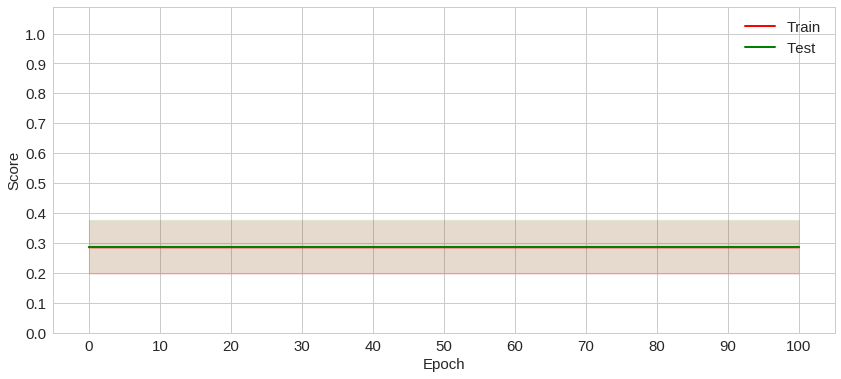

In [27]:
plot_mean_acc(hist)

In [28]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
plt.style.use('seaborn-whitegrid')

def plot_mean_loss(history):
    train_scores = np.zeros((len(history),len(history[0]['loss'])))
    for fold in range(len(history)):
        train_scores[fold] = history[fold]['loss']
    test_scores = np.zeros((len(history),len(history[0]['val_loss'])))
    for fold in range(len(history)):
        test_scores[fold] = history[fold]['val_loss']
    epochs = np.linspace(0, len(history[0]['loss']), len(history[0]['loss']))
    train_scores_mean = np.mean(train_scores, axis=0)
    train_scores_std = np.std(train_scores, axis=0)
    test_scores_mean = np.mean(test_scores, axis=0)
    test_scores_std = np.std(test_scores, axis=0)
    
    figsize=(14, 6)
    text_fontsize="medium"
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax.set_xlabel("Epoch", fontsize=text_fontsize)
    ax.set_ylabel("Score", fontsize=text_fontsize)
    ax.grid(True)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
    ax.fill_between(epochs, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1, color="r")
    ax.fill_between(epochs, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color="g")
    ax.plot(epochs, train_scores_mean, '-', color="r", linewidth=2.0, label="Train")
    ax.plot(epochs, test_scores_mean, '-', color="g", linewidth=2.0, alpha=0.7, label="Test")
    ax.tick_params(labelsize=text_fontsize)
    ax.legend(loc="best", fontsize=text_fontsize)
    x1,x2,y1,y2 = plt.axis()
    plt.axis((x1,x2,-3.9,17.9))
    plt.show()

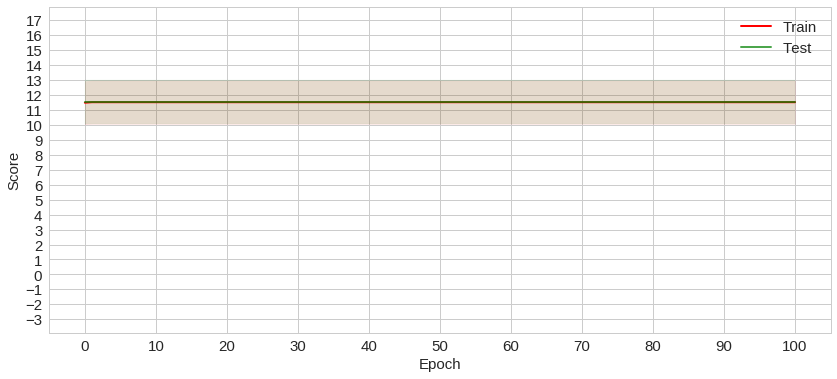

In [29]:
plot_mean_loss(hist)